In [78]:
import tensorflow as tf
tf.enable_eager_execution()#这东西还必须在最开始就执行，放后面都不行


In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
import matplotlib.pylab as plt
import tensorflow_hub as hub
from tensorflow.keras import layers



In [3]:
import os
path=os.path.abspath('.')
path

'/Users/allen/Desktop/tensorflow'

In [58]:
#from sklearn.model_selection import train_test_split
 

In [ ]:
## load data and image processing

data_root = tf.keras.utils.get_file(
  'food',
  'http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz',
   untar=True)

## normalize+变换一下图片的size。
IMAGE_SHAPE = (224, 224)

image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
        ##批量处理image的方法（旋转，裁剪，翻转等的图片批量处理的方法）
        #rescale（num）像素标准化！所有像素矩阵直接*num后
image_data = image_generator.flow_from_directory(str(data_root),
                                                     target_size=IMAGE_SHAPE,
                                                )

In [46]:
for image_batch, label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break



Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 5)


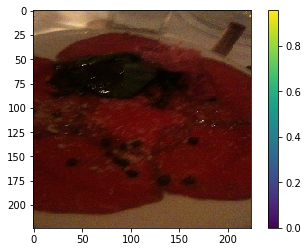

In [47]:

##show a imagine as same as matlab
plt.figure()
plt.imshow(image_batch[1])
plt.colorbar()
plt.grid(False)
plt.show()


In [15]:
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2" #@param {type:"string"}
#这是个字符串


In [16]:
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(224,224,3))

#keraslayer的obj是字符串类型的地址，可以是本地的也可以是URL（网页的）

In [17]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)
#image_batch还是一批花的image
#返回的是32个维度为1280的vector

(32, 1280)


In [18]:
#freeze我们不需要继续学习和修改的layer
feature_extractor_layer.trainable = False
#这里我们不需要在对我们下载下来的headless NN继续修改了

In [21]:
#新建一个以URL上的且不需要在改动的中心层为核心，在堆叠一个layer
model = tf.keras.Sequential([
  feature_extractor_layer,#我们直接把这个layer放在sequential的一层layer里面
  layers.Dense(image_data.num_classes, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [22]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='categorical_crossentropy',
  metrics=['acc'])

In [23]:
#自己写一个log版本的loss and acc
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):#先定义几个属性
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])#把loss one by one的放进来
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

In [81]:
image_data.batch_size
image_data.samples


49

In [24]:
import numpy as np
steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)

batch_stats_callback = CollectBatchStats()

history = model.fit(image_data, epochs=2,
                    batch_size=100,
                    callbacks = [batch_stats_callback])

Epoch 1/2


W0818 15:48:24.700579 4469220800 deprecation.py:323] From /Users/allen/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


20/20 [==============================] - 22s 1s/step - loss: 1.3864 - acc: 0.7188
Epoch 2/2
20/20 [==============================] - 23s 1s/step - loss: 0.8596 - acc: 0.8438


In [25]:
type(batch_stats_callback)

__main__.CollectBatchStats

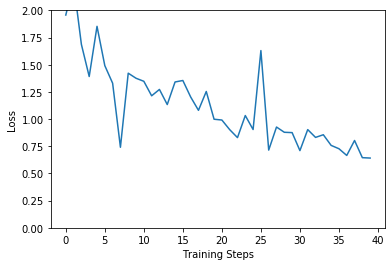

In [26]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

In [ ]:
image

In [27]:
class_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names

#tips：
#for的用法：
#[a + b for a in x for b in y if a%2 == 0 and b%2 ==0],一定用方括号廓起来
#这里两个for之间是嵌套的关系
#把x中的一个一个拿出来，赋值给a，同理从y中拿出来的元素，赋值给b，
#判定如果a和b都能被2整除，则执行a+b的操作


array(['Apple_Pie', 'Baby_Back_Ribs', 'Baklava', 'Beef_Carpaccio',
       'Cannoli'], dtype='<U14')

## prediction

In [60]:
IMAGE_SHAPE = (224, 224)


test_data = image_generator.flow_from_directory('/Users/allen/Desktop/tensorflow/database/food-test',
                                                     target_size=IMAGE_SHAPE)
#flow_from_directory, 指的明输入的位置，以str的形式


Found 49 images belonging to 3 classes.


In [61]:
for image_test, label_test in test_data:
  print("Image batch shape: ", image_test.shape)
  print("Label batch shape: ", label_test.shape)
  break


Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 3)


In [80]:
class_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names

#tips：
#for的用法：
#[a + b for a in x for b in y if a%2 == 0 and b%2 ==0],一定用方括号廓起来
#这里两个for之间是嵌套的关系
#把x中的一个一个拿出来，赋值给a，同理从y中拿出来的元素，赋值给b，
#判定如果a和b都能被2整除，则执行a+b的操作

array(['Apple_Pie', 'Baby_Back_Ribs', 'Baklava'], dtype='<U14')

In [70]:
#predict
predicted_batch = model.predict(image_test)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

In [74]:
label_id = np.argmax(label_test, axis=-1)

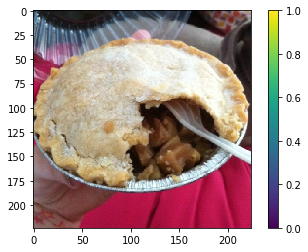

In [75]:
##show a imagine as same as matlab
plt.figure()
plt.imshow(image_test[1])
plt.colorbar()
plt.grid(False)
plt.show()

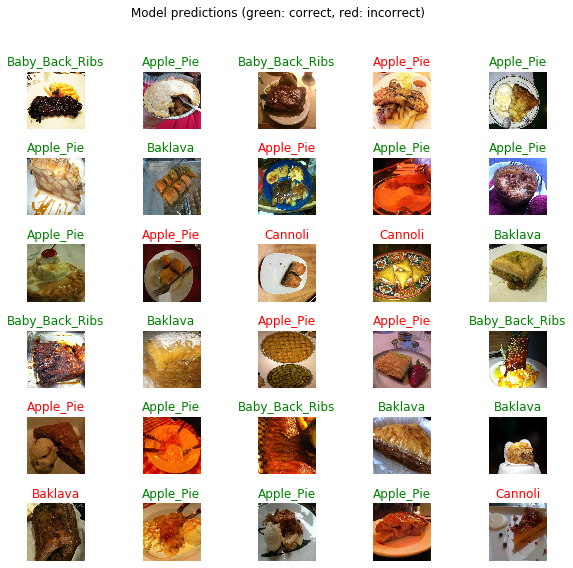

In [77]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_test[n])
  color = "green" if predicted_id[n] == label_id[n] else "red"
  plt.title(predicted_label_batch[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")